In [16]:
# **** take a look at mol graph conv featurizer

In [2]:
import networkx as nx
import numpy as np
# import pysmiles
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from collections import defaultdict
from typing import List, Optional, Tuple, Union
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix

import torch

from torch_geometric.utils import convert
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader



/Users/maxperozek/opt/anaconda3/envs/comp_gr_thy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
benzene = "C1=CC=CC=C1"
anisole = "COC1=CC=CC=C1"
bucky = 'C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23'


In [4]:
weight_map = {
    'SINGLE': 1,
    'AROMATIC': 1.5,
    'DOUBLE': 2,
    'TRIPLE': 3
}

In [5]:
def mol_to_graph(mol, data=None):
    if data:
        G = nx.Graph(
            bbb=data['BBB+/BBB-'], 
            y=1 if data['BBB+/BBB-']=="BBB+" else 0, 
            compound=data['compound_name']
        )
    else:
        G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), atomic_num=atom.GetAtomicNum(), is_aromatic=atom.GetIsAromatic(), symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        bond_weight = weight_map[str(bond.GetBondType())]
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType(), weight=bond_weight)
    
    return G

In [6]:
def draw_mol(G):
    pos = nx.spring_layout(G)
    elements = nx.get_node_attributes(G, name="symbol")
    labels = nx.get_edge_attributes(G,'weight')

    nx.draw(G, pos, with_labels=True, labels=elements)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

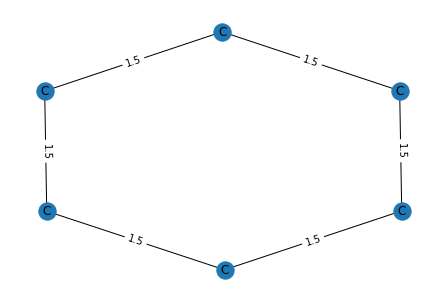

In [7]:
mol = Chem.MolFromSmiles(benzene)
G = mol_to_graph(mol, None)
draw_mol(G)

In [8]:
data = pd.read_csv("B3DB/B3DB/B3DB_classification.tsv", sep="\t")
data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")

/var/folders/ms/mpc19fxd7zz_dr0tr65kskdh0000gn/T/ipykernel_57049/283256523.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")


In [9]:
row = data.sample().iloc[0]

In [10]:
def data_from_smiles(smiles, display=False):
    mol = Chem.MolFromSmiles(smiles)
    G = mol_to_graph(mol)
    if display:
        display(mol)
        draw_mol(G)
    return convert.from_networkx(G)

CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(O)C[C@](C)(F)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O flurithromycin BBB-


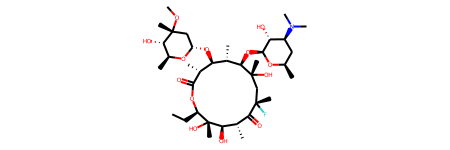

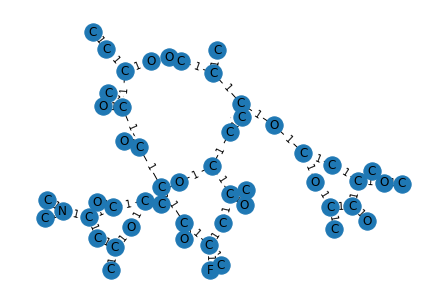

bbb: BBB-
y: 0
compound: flurithromycin


In [11]:
print(row['SMILES'], row['compound_name'], row['BBB+/BBB-'])

mol = Chem.MolFromSmiles(row['SMILES'])
display(mol)

G = mol_to_graph(mol, dict(row))
draw_mol(G)
for key, value in G.graph.items():
    print(f"{key}: {value}")

In [12]:
def from_networkx(G):
    G = nx.convert_node_labels_to_integers(G)
    edges = list(G.edges)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = defaultdict(list)
    data['edge_index'] = edge_index.view(2, -1)
    for key, value in G.graph.items():
        data[key] = value
    xs = []
    for i, (_, node_data) in enumerate(G.nodes(data=True)):
        for key, value in node_data.items():
            data[key].append(value)
    for i, (_, _, edge_data) in enumerate(G.edges(data=True)):
        for key, value in edge_data.items():
            data[key].append(value)
                            
    for key in ["atomic_num", "is_aromatic"]:
        xs.append(data[key])
        data['x'] = torch.tensor(xs)

    return Data.from_dict(data)

In [13]:
print(from_networkx(G))

Data(x=[2, 52], edge_index=[2, 54], y=0, bbb='BBB-', compound='flurithromycin', atomic_num=[52], is_aromatic=[52], symbol=[52], bond_type=[54], weight=[54])


3769 O=C1[C@H](O)N=C(c2ccccc2F)c2cc(Cl)ccc2N1CCO
unii-5efs516hk3 BBB+


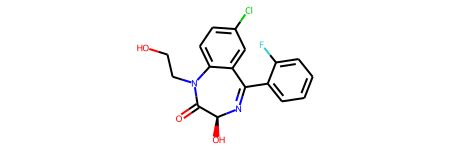

TypeError: string indices must be integers

In [14]:
for i, row in data.sample(10).iterrows():
    print(i, row['SMILES'])
    print(row['compound_name'], row['BBB+/BBB-'])
    mol = Chem.MolFromSmiles(row['SMILES'])
    display(mol)
    G = mol_to_graph(mol, row['BBB+/BBB-'])
    draw_mol(G)